In [1]:
%load_ext rpy2.ipython

# __________________________________________________

In [130]:
%%R
library(DESeq2, quietly = TRUE)
library(ggplot2, quietly = TRUE)
library(ggrepel, quietly = TRUE)
library(tidyverse, quietly = TRUE)
library(EnhancedVolcano, quietly = TRUE)
library(data.table, quietly = TRUE)
library(FactoMineR, quietly = TRUE)
library(factoextra, quietly = TRUE)

In [54]:
%%R
Volcano_plot <- function (df,pcut,dcut, comp){
    thr_p <- df$log2FoldChange >= dcut & -log10(df$padj) >= pcut
    thr_n <- df$log2FoldChange <= -dcut & -log10(df$padj) >= pcut
    # Make volcano plots
    vol = ggplot(df, aes(x=log2FoldChange,y=-log10(padj), label=Gene_name))  +
            geom_point(
                data = df[!thr_p&!thr_n,], 
                aes(x=log2FoldChange, y=-log10(padj), colour='a'), alpha = 8/10) +
            geom_point(
                data = df[thr_p|thr_n,], 
                aes(x=log2FoldChange,y=-log10(padj), colour='b'), alpha = 3/10)  +
            # set manual color 
            scale_colour_manual(values=c('gray', 'darkgreen')) +
            ggtitle(comp) +
            geom_label_repel(data=df[order(log10(df$padj)),][c(1:10),]) +
            theme_bw() + 
            theme(legend.position="none", plot.title = element_text(lineheight=.8, face="bold"))

#     ggsave(paste('Volcano_',comp,'.pdf',sep=''), plot = vol, device = 'pdf')
    print (vol)
}

run_deseq <- function (m,meta){
    colData <- data.frame('cond' = meta[,2], row.names=meta[,1])
    dds <- DESeqDataSetFromMatrix(countData = m[,meta$V1], colData = colData, design = ~ cond)
    dds$cond <- relevel(dds$cond, ref="metastasis")
    dds <- DESeq(dds)
    return(dds)
}

In [55]:
%%R
gene_name <- read.table('/rumi/shams/abe/Workflows/RNA-seq/data/id_transfer/hg38/EnsemblIDtoGeneName.txt',header = T, sep = "\t", stringsAsFactors = F)

# # step 1: read count files 
# meta data
meta <- read.table('dataset/meta.txt', header = F, sep = "\t", stringsAsFactors = F)
meta.rep <- read.table('dataset/meta_1.txt', header = F, sep = "\t", stringsAsFactors = F)
# read data 
m <- read.table('dataset/exp/featureCounts_rpm_exp.txt',header = T, sep = "\t", stringsAsFactors = F)
rownames(m) <- m[,1]
m <- m[,-1]
m[is.na(m)]<-0
m <- round(m)
colnames(m) <- meta.rep[,1]
# data imputation: replace mean & round of reps
for (r in grep('rep1', meta.rep[,1], value=TRUE)){
    key <- unlist (strsplit(r, 'rep'))[1]
    if (length(grep(key, meta.rep[,1])) > 1){
        # remove not 'rep1' Obs. & remove 'rep' in names
        reps <- meta.rep$V1[grep(key, meta.rep[,1])]
        meta.rep[meta.rep[,1] %in% r,1] <- paste(key, 'ave', sep = '')
        meta.rep <- meta.rep[!meta.rep[,1] %in% reps,]
        m[,paste(key, 'ave', sep = '')] = round(apply(m[,grep(key, colnames(m))],1, mean))
        m <- m[,!colnames(m) %in% reps ]
    } else {
        # remove 'rep' in names
        meta.rep[which(meta.rep == r),1] <-  unlist (strsplit(r, '_'))[1]       
}}
colnames(m) <- gsub('_rep1','', colnames(m))
met_vs_bio <- meta.rep[meta.rep[,2] %in% c('metastasis', 'biopsy'),]
met_vs_res <- meta.rep[meta.rep[,2] %in% c('metastasis', 'resection'),]

In [ ]:
%%R
# dds <- run_deseq(m,meta.rep)
# cds <- estimateDispersions(dds)
# vsd <- varianceStabilizingTransformation(cds)
# # PCA Plot 
# z <- plotPCA(vsd,intgroup=c("cond"), returnData=TRUE)
# percentVar <- round(100 * attr(z, "percentVar"))
# p <- ggplot(z, aes(PC1, PC2)) +
#   geom_point(aes(size = 4)) +
#   xlab(paste0("PC1: ",percentVar[1],"% variance")) +
#   ylab(paste0("PC2: ",percentVar[2],"% variance")) +
#   geom_label_repel(label = colData$cond, force = 10) +
#   guides(size = FALSE)
# print (p)

### metastasis VS biopsy

R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 1245 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



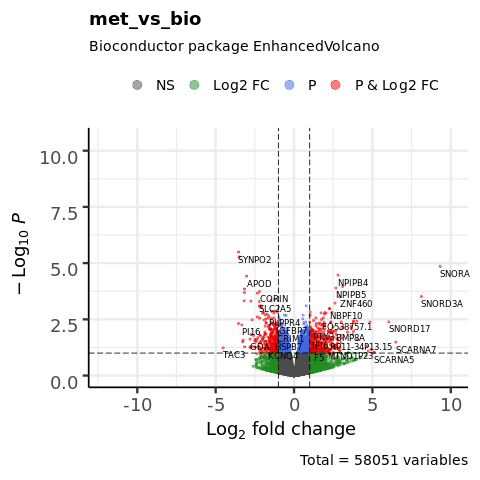

In [57]:
%%R
# # step 2: make DESeq object 
dds <- run_deseq (m, met_vs_bio)

# # step 3: normalize counts 
ncu <- counts(dds, normalized=TRUE)
res <- results(dds)
# Volcanoplot 
res <- data.frame(res, row.names = rownames(res))
rownames(res) <- make.unique(gene_name$Gene_name[gene_name$Gene_ID %in%  rownames(res)])
vol <- EnhancedVolcano(res,
    lab = rownames(res),
    x = 'log2FoldChange',
    y = 'pvalue',
    xlim = c(-12, 10),
    title = 'met_vs_bio',
    pCutoff = 1e-1,
    FCcutoff = 1)
print (vol)

R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 1054 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



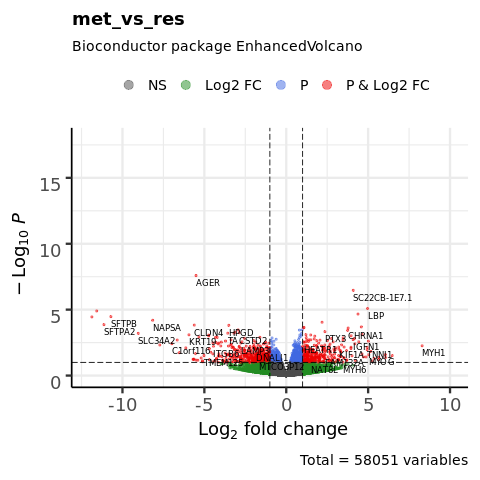

In [58]:
%%R
# # step 2: make DESeq object 
dds <- run_deseq (m, met_vs_res)

# # step 3: normalize counts 
ncu <- counts(dds, normalized=TRUE)
res <- results(dds)
# Volcanoplot 
res <- data.frame(res, row.names = rownames(res))
rownames(res) <- make.unique(gene_name$Gene_name[gene_name$Gene_ID %in%  rownames(res)])
vol <- EnhancedVolcano(res,
    lab = rownames(res),
    x = 'log2FoldChange',
    y = 'pvalue',
    xlim = c(-12, 10),
    title = 'met_vs_res',
    pCutoff = 1e-1,
    FCcutoff = 1)
print (vol)

Replicate Alex script:

In [176]:
%%R
# knitr::opts_chunk$set(include=T, echo=T, message=FALSE, warning=FALSE, fig.show="asis", fig.keep="all",tidy.opts=list(width.cutoff=100),tidy=TRUE)
# options(knitr.table.format = "latex")

# ## global options 
# options(scipen=999)
# ## shared variable 
# library("RColorBrewer")
# getPalette = colorRampPalette(brewer.pal(9, "Set1")) # expand color pallete
# ss = 123
# set.seed(ss)
# run estimate to get stromal and 
# run.e = 0
# lets load up the require modules and functions 
# source ( "configos.R")
# KEY = 1
# do.gsva = 1

# ######################################################################################################### #
# # step 1: make sure that key is saved and can be retrieve

# if (KEY == 1) {
#     rna.key <- read.xlsx(key.file, sheet = "masterkey.stable.txt")
#     rna.key = rna.key[rna.key$RNAseq.id != "None", ]
#     rna.key = rna.key[rna.key$cancer.subtype == "OS", ]
    
#     rna.key = rna.key[rna.key$sample.source == "patient", ]
#     rna.key = rna.key[!is.na(rna.key$patient.id), ]
    
#     rna.key$sample.classification = toupper(rna.key$sample.classification)
#     # manually change, here be dragos, this sample was Diagnostic_Biopsy
#     rna.key[rna.key$patient.id == "566", ]$sample.classification = "PRIMARY"
#     saveRDS(rna.key, "key.rds")
# } else {
#     rna.key = readRDS("key.rds")
# }

rna.key = meta.rep
names(rna.key) = c('RNAseq.id','sample.type')

all.os = as.character(unique(rna.key[,2]))


In [177]:
%%R
# ######################################################################################################### #
# # step 2: remove samples that were removed in version 2.  remove parent.sample == 567-3 128-1
# # (Z1,Z13) and 622-3 (AY5 ) remove rna.key = rna.key[!rna.key$RNAseq.id %in% c('T1','AY5') , ]

# rna.key = rna.key[!rna.key$parent.sample %in% c("567-3", "128-1", "622-3"), ]

rna.key$group = ifelse(grepl("met", rna.key$sample.type), "met", rna.key$sample.type)
rna.key = rna.key[order(rna.key$group), ]

# # 2b keep only groups were are going to be using.
# rna.key = rna.key[rna.key$sample.type %in% c("Diagnostic_Biopsy", "Resection", "Metastasis", "Relapse_Metastasis"), 
#     ]

# sample.type = as.matrix(table(rna.key$sample.type, rna.key$sample.classification))

# sample.gender = data.frame(table(rna.key$sex))
# colnames(sample.gender) = c("gender", "Freq")


# rna.key = rna.key[, c("patient.id", "RNAseq.id", "parent.sample", "sex", "sample.type", "sample.classification", 
#     "RNAseq.platform", "group")]
# rna.key = rna.key[order(rna.key$group, rna.key$sample.classification, rna.key$patient.id, rna.key$parent.sample), 
#     ]

# ######################################################################################################### #
# # step 3 sum duplicates
# dups = rna.key[duplicated(rna.key$parent.sample), ]$parent.sample
# # ignore samples with the same parent.sample for now
# same.parent = dups
# dupsample = which(rna.key$parent.sample %in% same.parent)


# ## get counts
data = m

# count_dir = "../../zscore/counts/counts.rds"
# data = readRDS(count_dir)

# # don't have counts for
# noc = rna.key[rna.key$RNAseq.id %in% setdiff(rna.key$RNAseq.id, names(data$raw.counts)), ]

# noc = as.character(noc$RNAseq.id)
# noc = which(rna.key$RNAseq.id %in% noc)


# data = data$raw.counts[, names(data$raw.counts) %in% as.character(rna.key$RNAseq.id)]

# # here be dragons: sum is manaul since keep track of which tube to remove from key later
# rm.key = c()
# for (s in same.parent) {
#     s = rna.key[rna.key$parent.sample == s, ]$RNAseq.id
#     # does it exists in data?
#     ex = colnames(data)[colnames(data) %in% s]
#     if (length(ex) >= 2) {
#         # remove from data first
#         new = data[, s]
#         data = data[, !colnames(data) %in% s]
#         # sum new by row
#         new = rowSums(new)
#         # randomely chose one s
#         new = data.frame(s = as.numeric(new))
#         colnames(new) = s[1]
#         data = cbind(new, data)
#         # remove the rest from the key
#         rm.key = c(rm.key, s[-1])
#     }
# }

# ######################################################################################################### #
# step 4b: normalize library

data = data.table::setcolorder(data, rna.key$RNAseq.id)
all.equal(colnames( data), rna.key$RNAseq.id)
## [1] TRUE

[1] TRUE


In [178]:
%%R
# normalize 

match.data <- data
match.data <- setcolorder( match.data , as.character(meta.rep[,1]))

# normalize library 
y.match <- DGEList( match.data)

## remove low counts since this could interfere with some of the statistical approximations
#  here half the total sample size must have > 1 cpm to be included 
threshold <- ncol(match.data)/2
keep <- rowSums( cpm(y.match)  > 0) >= threshold

In [179]:
%%R
# before 
dim(y.match)
## [1] 20213    50

[1] 58051    37


In [180]:
%%R
y.match  <- y.match [keep, ]
# after 
dim (y.match)
## [1] 16817    50

[1] 15614    37


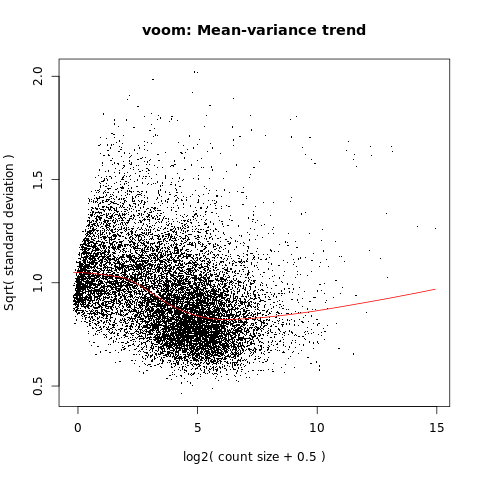

In [181]:
%%R
## normalisation using trimmed mean of M-values (TMM) (Robinson and Oshlack 2010)
## this will stablize rna composition 

y.match <- calcNormFactors( y.match, method = "TMM" )

# set design for your experiment. 

design.plate <- model.matrix(~0  +  rna.key$group )
colnames(design.plate) = gsub ( "rna.key\\$sample.classification", "", colnames ( design.plate) )


voom <- voom(y.match, plot=T, design = design.plate) 

In [182]:
%%R
voomplot <- recordPlot()

# get cpm values 
cpm <-  data.frame (  cpm(y.match, log=T, prior.count=3)  )
cpm_nolog <-  data.frame (  cpm(y.match, log=F, prior.count=3)  )

# if ( run.e == 1){
#     library(estimate)
#     cpm2 <-  data.frame (  cpm(y.match, log=T, prior.count=3)  )
    
#     ifelse(!dir.exists(file.path("ESTIMATE")), dir.create(file.path("ESTIMATE")), FALSE)
#     #cpm2$GeneSymbol = NULL
#     write.table(cpm2 ,file = "ESTIMATE/cpm_matrix.txt", quote = F, row.names = T, col.names = T, sep = "\t")
#     filterCommonGenes(input.f="ESTIMATE/cpm_matrix.txt", output.f="ESTIMATE/ematrix.gct", id="GeneSymbol")
#     estimateScore("ESTIMATE/ematrix.gct", "ESTIMATE/score.gct", platform="illumina")
#     est = t(data.frame(fread("ESTIMATE/score.gct", skip = 2)[,-1], row.names = T))
#     # estiamte purity 
#     estimate_purity = cos(0.6049872018 + 0.0001467884*est[,3])
#     est = data.frame ( est, stringsAsFactors = F)
#     est$purity = as.numeric ( estimate_purity  )
#     saveRDS(est, "ESTIMATE/OS.rds")
# }else {
#     est = readRDS( "ESTIMATE/OS.rds" )
# }

# est = est[ order ( -est$purity), ]
# est$tube = factor ( row.names( est ), levels= row.names(est) )
# pur = ggplot(est,aes(x = tube, y= purity  )) + 
#     geom_bar(stat="identity", fill = "#03b6fc") + 
#    geom_hline(yintercept = .5, color="red") +
#     theme(legend.position="none", legend.title=element_blank(), legend.key = element_blank(),
          
#           axis.text.y = element_text(size=12),
#           axis.text.x = element_text(angle = 90, size=11.5),
#           axis.title.x = element_text(size=22),
          
#           axis.title.y     = element_text(size=22), 
#           legend.text      =element_text(size=12), 
#            axis.ticks.y=element_blank(),
#             panel.grid.major = element_blank(), 
#             panel.grid.minor = element_blank(),
#             panel.background = element_blank()
#     ) +xlab("sample")

# plot immunoe scores 
# stromal = plot.heat ( est, legend="none",fill_high="blue", fill_low = "white"
#                   , groupname = "Stromal"
#                   ,xthis="tube", fthis = "StromalScore")
# # immune 
# immune = plot.heat ( est, legend="none",fill_high="red", fill_low = "white"
#                   , groupname = "ims"
#                   ,xthis="tube", fthis = "ImmuneScore")

# # now plot density 

# temp = melt (cpm )
# colnames(temp) = c("sample", "value")
#   g = ggplot(temp, aes(value, fill=sample, colours=sample)) + geom_density(alpha=0.1) + 
#       theme_bw()  + scale_color_manual( values= getPalette(12))

  
 
# bo = box.outlier( cpm, key=rna.key, group.id="sample.classification" , tname="RNAseq.id" )


# # get basic QC scores 


# qc = "../../../RNA-SEQ/QC/QC.RNA.rds"
# qc = readRDS(qc)
# qc2 = read.table("../../../RNA-SEQ/QC/p1_QC.csv", header=TRUE,sep=",",stringsAsFactors = FALSE,na.strings=".",  quote = "")
# qc2$dataset = NULL
# qc$dataset = NULL
# qc$Uniquely.Mapped.NonDupeReads = NULL

# qc.df <- rbind ( qc,qc2)
# qc.df = qc.df[qc.df$sample %in% unique (  all.os), ]
# qc.plot <- qcbar(qc.df,key=rna.key,group.col="sample.classification",tube="RNAseq.id")


# # save to workbook
# wb  <- createWorkbook()
# addWorksheet(wb, 'ESTIMATE')
# writeData(wb, 'ESTIMATE', est)

# addWorksheet(wb, 'QC')
# writeData(wb, 'QC', qc.df)

In [183]:
%%R
# ######################################################################################################### #
# step 5: we are anlayzing specifically the following 
#- diagnostic biopsy  to relapsed metastasis + metastasis 
#- resection to relapsed metastasis + metastasis

# colorcode groups 

# rna.key$scolor = ifelse(rna.key$sample.classification=="NONPRIMARY", "red", "grey")
rna.key$scolor = ifelse(rna.key$group!="met", "Primary", "NONPrimary")

Diagnostic_Biopsy = "blue"
Resection = "green"
#Metastasis|Relapse_Metastasis = "red"


# rna.key$class_color = ifelse ( 
#         grepl ( "Diagnostic_Biopsy", rna.key$sample.type), Diagnostic_Biopsy, 
#         ifelse ( grepl ( "Resection", rna.key$sample.type , Resection), Resection, 
#             ifelse ( grepl ( "Metastasis|Relapse_Metastasis", rna.key$sample.type)  , "red", "white")     
#                  )
#         )

# ######################################################################################################### #
# unsupervised 
# reorganize key 
# step 5c: for unsupervised we need to create seperate keys. 
table ( rna.key$group)
## 
## Diagnostic_Biopsy               Met         Resection 
##                18                20                12


   biopsy       met resection 
       18        11         8 


In [184]:
%%R
key.biop = rna.key[ rna.key$sample.type %in% c( "biopsy", "metastasis"),  ]
key.resec = rna.key[ rna.key$sample.type %in% c( "resection", "metastasis"),  ]

cpm.biop = cpm[ , key.biop$RNAseq.id]
all.equal(names( cpm.biop), key.biop$RNAseq.id)
## [1] TRUE


[1] TRUE


In [185]:
%%R
cpm.resec = cpm [ , key.resec$RNAseq.id]
all.equal(names( cpm.resec), key.resec$RNAseq.id)

[1] TRUE


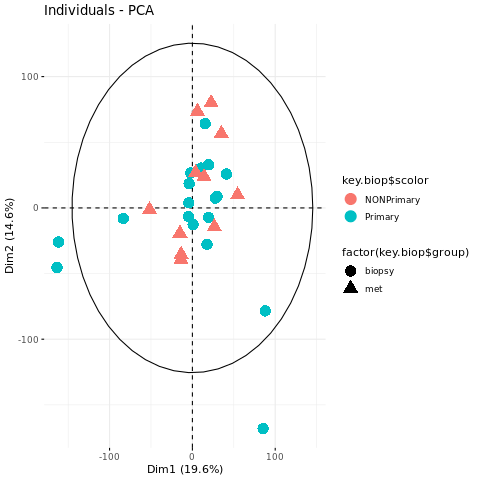

In [189]:
%%R
# step 5e: do biop vs met unsupervised
cm.cpm = cpm.biop 

# sd <- apply (cm.cpm, 1,  function(x) cov(x)  )
# head(cm.cpm)
# p = c(.1,.2,.3,.4,.5,.6, .7, .75, .8, .9,.95)
# q <- quantile (as.numeric ( sd ), probs = p , na.rm =T )

# # what prob do you want? 
# get.p = "90%"
# get.p = as.numeric ( q[get.p] )
# sd2 = sd[ !is.na(sd) & sd >get.p  ]

# # from here on out cm.cpm2 is the main one since cm.cpm changes 
# cm.cpm = cm.cpm [ row.names ( cm.cpm) %in% names( sd2), ]


# dend2 = makehr ( t( cm.cpm ), km=3, dist.this = "manhattan", meta1 = key.biop$group )    

# dend2$dend = dend2$dend %>% set("labels_cex", 0) %>% set("labels_col", "white")
# #attributes(dend2)$Labels<- paste ( "a", seq(1, ncol(cm.cpm2)) )



# par(mar=c(5,5,2,10))
# # c(bottom, left, top, right)
# plot ( dend2$dend, horiz=T) 


# ###
# colored_bars(colors = cbind ( 
#                             group=key.biop$class_color
#                                 )
#              , dend =  dend2$dend, sort_by_labels_order = TRUE, horiz = T, text_shift=0, x_scale=0)

# ###
hr.biop <- recordPlot()
pca.biop <- PCA( t( cm.cpm), graph = FALSE)

p <- fviz_pca_ind(pca.biop, label="none", addEllipses=TRUE, ellipse.level=0.95,  axes = c(1, 2))
p2 <- p +geom_point(aes(colour= key.biop$scolor, shape= factor(key.biop$group) ), size=5.0  )
# pca.biop = p2  + 
# scale_colour_discrete(name  ="Key") + scale_shape_discrete ( name="Classification") + ggtitle("Gender")
print (p2)

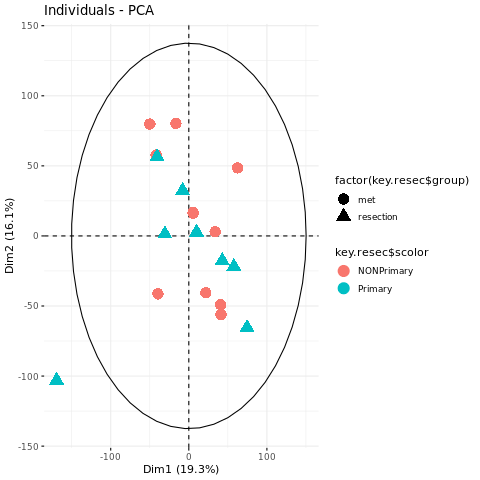

In [190]:
%%R
# ###
# step 5f, resec vs met unsuper

cm.cpm = cpm.resec 

# sd <- apply (cm.cpm, 1,  function(x) cov(x)  )

# p = c(.1,.2,.3,.4,.5,.6, .7, .75, .8, .9,.95)
# q <- quantile (as.numeric ( sd ), probs = p , na.rm =T )

# # what prob do you want? 
# get.p = "90%"
# get.p = as.numeric ( q[get.p] )
# sd2 = sd[ !is.na(sd) & sd >get.p  ]

# # from here on out cm.cpm2 is the main one since cm.cpm changes 
# cm.cpm = cm.cpm [ row.names ( cm.cpm) %in% names( sd2), ]


# dend2 = makehr ( t( cm.cpm ), km=3, dist.this = "manhattan", meta1 = key.resec$group )    

# dend2$dend = dend2$dend %>% set("labels_cex", 0) %>% set("labels_col", "white")
# #attributes(dend2)$Labels<- paste ( "a", seq(1, ncol(cm.cpm2)) )


# par(mar=c(5,5,2,10))
# # c(bottom, left, top, right)
# plot ( dend2$dend, horiz=T) 

# colored_bars(colors = cbind ( 
#                             group=key.resec$class_color
#                                 )
#              , dend =  dend2$dend, sort_by_labels_order = TRUE, horiz = T, text_shift=0, x_scale=0)
# ###
hr.biop <- recordPlot()
pca.resec <- PCA( t( cm.cpm), graph = FALSE)

p <- fviz_pca_ind(pca.resec, label="none", addEllipses=TRUE, ellipse.level=0.95,  axes = c(1, 2))
p2 <- p +geom_point(aes(colour= key.resec$scolor, shape= factor(key.resec$group) ), size=5.0  )
# pca.resec = p2  + 
# scale_colour_discrete(name  ="Key") + scale_shape_discrete ( name="Classification") + ggtitle("Gender")
print (p2)

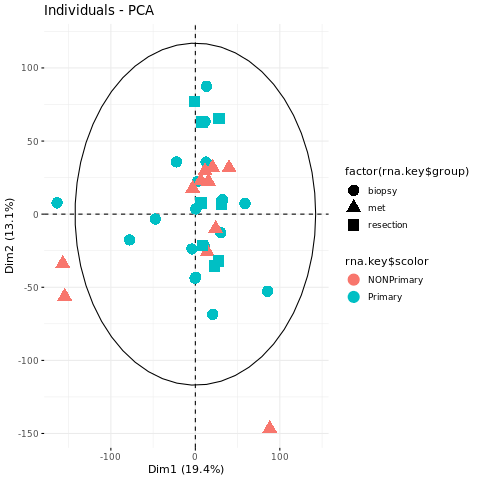

In [191]:
%%R
# ######################################################################################################### #

# PCA
hr.resec <- recordPlot()
rna.pca <- PCA( t(cpm), graph = FALSE)

p <- fviz_pca_ind(rna.pca, label='none', addEllipses=TRUE, ellipse.level=0.95,  axes = c(1, 2))
p2 <- p +geom_point(aes(colour= rna.key$scolor, shape= factor(rna.key$group) ), size=5.0  )
# # pca.resec = p2  + 
# # scale_colour_discrete(name  ="Key") + scale_shape_discrete ( name="Classification") + ggtitle("Gender")
print (p2)


In [ ]:
%%R
# step 6 GSVA

# colnames(design.plate) = gsub("rna.key\\$group", "", colnames(design.plate))

# if (do.gsva == 1) {
#     # lets test for some pathways!
#     pathways = list()
#     gmt = paste0("../../../remote.sources/gsea/basics/", list.files("../../../remote.sources/gsea/basics/", 
#         pattern = "gmt"))
    
    
#     for (g in gmt) {
#         gmt.file <- g
#         pathways = append(pathways, gmtPathways(gmt.file))
#     }
    
#     gsva.plate <- gsva(as.matrix(cpm), pathways, min.sz = 50, max.sz = 500000, mx.diff = TRUE, verbose = FALSE, 
#         parallel.sz = 2, kcdf = "Gaussian", method = "gsva")
#     saveRDS(gsva.plate, "gsva2.plate")
    
#     # run a quick limma model
    
#     fit <- lmFit(gsva.plate, design.plate)
    
#     # here we create the contrasts as described above relative first
#     contrast.matrix <- makeContrasts(biop = Met - Diagnostic_Biopsy, resec = Met - Resection, levels = design.plate)
#     # run model and extract data
#     fit.r <- contrasts.fit(fit, contrast.matrix)
#     fit.r <- eBayes(fit.r)
    
    
    
#     gsva.biop <- topTable(fit.r, coef = "biop", n = Inf)
#     gsva.resec <- topTable(fit.r, coef = "resec", n = Inf)
    
    
#     gsva.biop = gsva.biop[gsva.biop$P.Value < 0.05, ]
#     gsva.resec = gsva.resec[gsva.resec$P.Value < 0.05, ]
    
#     gsva.biop <- merge(gsva.biop, gsva.plate[, key.biop$RNAseq.id], by = "row.names")
#     colnames(gsva.biop)[1] <- "gene"
    
#     gsva.resec <- merge(gsva.resec, gsva.plate[, key.resec$RNAseq.id], by = "row.names")
#     colnames(gsva.resec)[1] <- "gene"
    
    
#     all.equal(names(gsva.biop[, 8:ncol(gsva.biop)]), key.biop$RNAseq.id)
#     all.equal(names(gsva.resec[, 8:ncol(gsva.resec)]), key.resec$RNAseq.id)
    
    
#     hm.gsva.biop = custom.hm(dff2 = gsva.biop[, 8:ncol(gsva.biop)], km1 = 3, km2 = 3, dist.this = "euclidean", 
#         aggreg = "ward.D2", color.df = cbind(group = cbind(group = key.biop$class_color)))
    
    
    
# }


In [ ]:
%%R
# step 7 now do the actual analysis
# fit <- lmFit(voom, design.plate)

# # here we create the contrasts as described above relative first
# contrast.matrix <- makeContrasts(biop = Met - Diagnostic_Biopsy, resec = Met - Resection, levels = design.plate)
# # run model and extract data
# fit.r <- contrasts.fit(fit, contrast.matrix)
# fit.r <- eBayes(fit.r)

# result.biop <- topTable(fit.r, coef = "biop", n = Inf)
# result.resec <- topTable(fit.r, coef = "resec", n = Inf)


# result.biop <- merge(result.biop, cpm[, key.biop$RNAseq.id], by = "row.names")
# result.resec <- merge(result.resec, cpm[, key.resec$RNAseq.id], by = "row.names")

# colnames(result.biop)[1] <- "gene"
# colnames(result.resec)[1] <- "gene"
# rsub <- colnames(result.biop)[1:7]

# hist.biop <- do.histo(result.biop)
# hist.resec <- do.histo(result.resec)



# pv = 0.05
# fdr.biop = 0.05
# logfc.biop = 1.2


# post.biop <- plot.post(result.biop, "group", "group", key.biop, rsub, exp.group = "group", exp.this = "Met", 
#     normal.this = "Diagnostic_Biopsy", sample.id = "RNAseq.id", GENE_SYMBOL = "gene", fdr = fdr.biop, 
#     fold_thres = logfc.biop, title1 = "Met vs Diagnostic_Biopsy", top10 = NA)


In [139]:
%%R
# post.biop$hmstat

In [ ]:
%%R
# hist.biop$logfc = hist.biop$logfc + geom_vline(xintercept = logfc.biop, color = "purple") + geom_vline(xintercept = -logfc.biop, 
#     color = "purple") + geom_text(aes(x = -logfc.biop, label = -logfc.biop, y = 2000), colour = "black", 
#     angle = 0) + geom_text(aes(x = logfc.biop, label = logfc.biop, y = 2000), colour = "black", angle = 0)

# hist.biop$p.value = hist.biop$p.value + geom_vline(xintercept = pv, color = "red")

# hist.biop$fdr = hist.biop$fdr + geom_vline(xintercept = fdr.biop, color = "red") + geom_text(aes(x = fdr.biop, 
#     label = fdr.biop, y = 200), colour = "black", angle = 0)


# # create own hm geodesic manhattan


# # sig genes
# sig.biop = post.biop$data[post.biop$data$class != "no-change", ]$gene
# hm1.biop = custom.hm(dff2 = cpm[sig.biop, key.biop$RNAseq.id], km1 = 4, km2 = 4, dist.this = "euclidean", 
#     aggreg = "ward.D2", color.df = cbind(group = cbind(group = key.biop$class_color)))
